# CS 449 Final Project Update

Due: May 23, 2023 at 11:59pm

## 1. Names and Net IDs

Tyler Dempski, ted4152
Ryan Philip, rdp4481
Peter Ha, pth1573
Zafir Ansari, zai1630

## 2. Abstract

*Write a new abstract that describes the motivation for your project and proposed methods. This should reflect any changes you've made, but you'll explain those changes later.*

Our project uses two main deep learning model architectures, an LSTM and a Convolutional Neural Network, to predict the price of a stock a given time interval in the future. This project will allow the user to choose a training interval and a prediction window for which they would like results. Additionally, this project will include another model trained with Reinforcement Learning to optimally buy and sell stocks to maximize profit.


## 3. Big Changes

*Describe any major changes that have taken your project in a new direction. What made you decide to make these changes? Were some things easier or harder than you expected?*

We previously intended to train two different LSTM models, one that predicted a binary output of up or down for a stock price, and another that predicted the actual price of the stock in the given prediction window. However, after implementing the first LSTM, we decided to switch one of our LSTM models to a CNN to get experience with building and using other types of models as well as comparing them to observe relative performance. We plan to train one LSTM to predict percent increase in the prediction window and one CNN to predict the same thing, and then analyze the results of both to see why one outperforms the other. Additionally, we plan to combine the two to make an LSTM with a CNN layer to see if that is more effective. This idea is based on a paper by Kanwal, A. et al. cited below.

Another change we are making in our project is adding an extra desired goal since our second essential goal of implementing the model to work on many different types of secruities was much easier than we expected. The main reason for this is because we realize after implementing the LSTM for regular stocks, it was a trivial update to allow for other types of securities. The only real change was finding the data. Because of this, we have added the new desired goal of creating an ensemble with the LSTM, a CNN, and an LSTM/CNN combo that flow into an MLP. Additionally, this MLP will take more information such as volume and volatility into account when making predictions. Then, we will use the outputs of the MLP as inputs to the Trader which we can use to test against the LSTM and CNN models alone.

## 4a. Describe your dataset(s)

*This should be an updated version of your datasets section from your proposal. Write this section as if the reader hasn't read your original proposal. List the datasets you're using, where you found them, and what they contain. Be detailed! For each dataset, what does the data look like? What is the data representation? (e.g., what resolution of images? what length of sequences?) How is the data annotated or labeled? Include citations for the datasets. Include at least one citation of previous work that has used this data, or an explanation of why it hasn't been used before*

Datasets:
1) Kaggle dataset: https://www.kaggle.com/datasets/svaningelgem/nyse-daily-stock-prices?select=ABBV.csv
    - can pull high, low, open, close
    - all data is daily
    - timeseries data (many rows, 4 columns), one page per stock
    - all data is labeled
    - This dataset has not been used on any projects yet. It is a relatively new dataset (created March 14).

>
2) Peter's python script to pull from Yahoo Finance to Pandas df
    - can pull high, low, open, close, volume, and adjusted close as well as a smattering of technical analysis
    - can pull weekly, daily, hourly, and by minute
    - timeseries data (many rows, 14 columns), each row has the stock name as a column
    - all the data is labeled
    - Peter has used this dataset previously to run his own stock market machine learning models.

>
3) Wharton Dataset
    - Recieved access through Kellogg
    - Can access historical S&P 500 components, fundamentals, as well as daily price.
    - Price and quote data (e.g. Open, close, bid/low, ask/high, trade-only)
    - Holding period returns with and without dividends
    - Excess returns and other derived data items
    - Market capitalization, shares outstanding, trading volume, corporate actions
    - Data is labeled, can be output in multiple formats, used by thousands of academics and universities worldwide for research.

## 4b. Load your dataset(s)

*Load at least a few examples and visualize them as best you can*

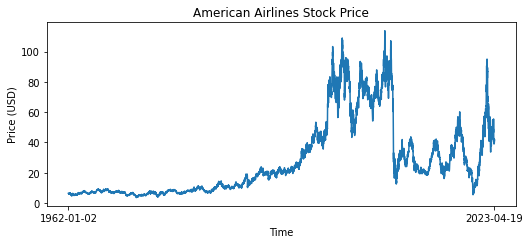

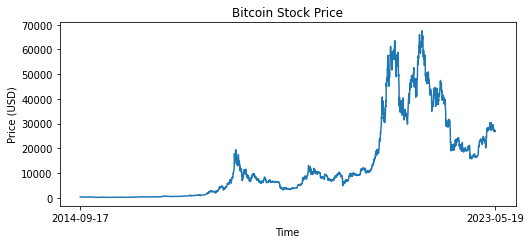

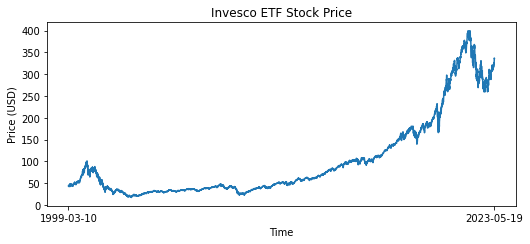

In [82]:
# Show dataReader file exceprt here
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

def graphStock(path,name):
    plt.rcParams["figure.figsize"] = [7.5,3.5]
    plt.rcParams["figure.autolayout"] = True

    stockData = pd.read_csv(path
                         ,usecols=["date","close"])
    plt.plot(stockData.date,stockData.close)
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.title(f'{name} Stock Price')
    plt.xticks([0,len(stockData.index)-1])
    plt.show()

graphStock("StockDataDaily/AA.csv","American Airlines")
graphStock("YFinanceStockData/BTC.csv","Bitcoin")
graphStock("YFinanceStockData/QQQ.csv","Invesco ETF")


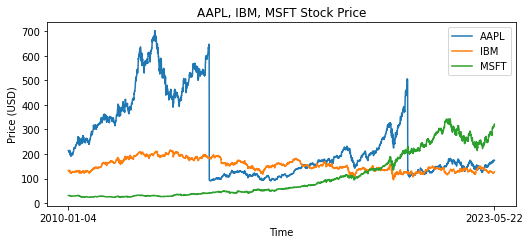

In [88]:
plt.rcParams["figure.figsize"] = [7.5,3.5]
plt.rcParams["figure.autolayout"] = True

stockData = pd.read_csv("WhartonDatasets/AAPL_IBM_MSFT_Wharton.csv",usecols=["datadate","prccd","tic"])
stockData = stockData.set_index(["datadate"])
plt.plot(stockData[["prccd", "tic"]].set_index("tic", append=True).prccd.unstack("tic"))
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title('AAPL, IBM, MSFT Stock Price')
plt.legend(["AAPL", "IBM", "MSFT"])
plt.xticks([0,len(stockData.index)/3-1])
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


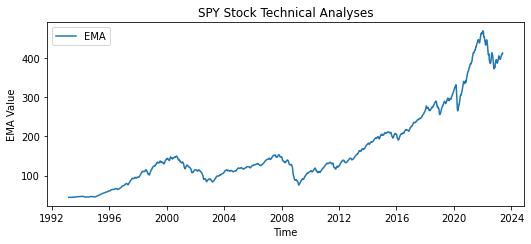

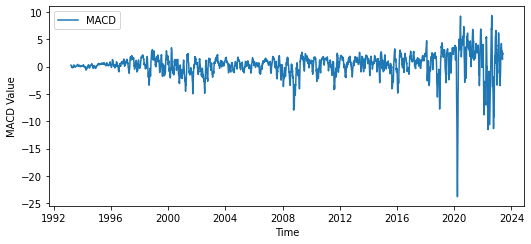

In [87]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from talib import abstract

# create empty dataframe
stock_final = pd.DataFrame()
tickers = ["SPY"]

# iterate over each symbol
EMA = abstract.Function('ema')
MACD = abstract.Function('macd')
STDDEV = abstract.Function('stddev')
AD = abstract.Function('ad')
NATR = abstract.Function('natr')

# Close, 'Volume', 'EMA', 'MACD','STDDEV', 'AD', 'ADOSC','NATR'
vix = yf.download("^VIX", period="max", progress=True)
vix = vix.rename(columns={"Close": "Volatility"})
vix = vix[["Volatility"]]

for i in tickers:

    # download the stock price
    stock = []
    stock = yf.download(i, interval="1d", progress = True)

    # append the individual stock prices
    if len(stock) == 0:
        None
    else:
        stock = pd.merge(stock, vix, on="Date")
        calc_ema = EMA(stock["Close"], timeperiod=26)
        calc_macd = MACD(stock["Close"])
        calc_stddev = STDDEV(stock["Close"])
        calc_ad = AD(stock["High"],stock["Low"],stock["Close"], stock["Volume"])
        calc_natr = NATR(stock["High"],stock["Low"],stock["Close"])
        stock["EMA"] = calc_ema
        stock["MACD"] = calc_macd[0]
        stock["STDDEV"] = calc_stddev
        stock["AD"] = calc_ad
        stock["NATR"] = calc_natr
        stock.insert(loc=1, column='Date', value=stock.index)

    stock_final = stock_final.append(stock, sort=False)

plt.rcParams["figure.figsize"] = [7.5,3.5]
plt.rcParams["figure.autolayout"] = True

stockData = stock_final
plt.plot(stockData.Date, stockData.EMA, label="EMA")
plt.legend()
plt.xlabel("Time")
plt.ylabel("EMA Value")
plt.title(f'{tickers[0]} Stock Technical Analyses')
plt.show()
plt.xlabel("Time")
plt.ylabel("MACD Value")
plt.plot(stockData.Date, stockData.MACD, label="MACD")
plt.legend()
plt.show()



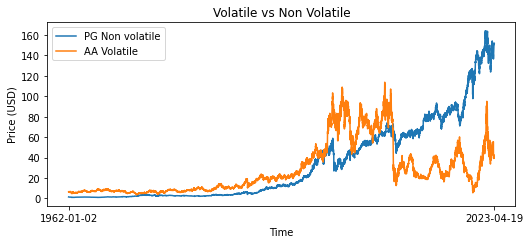

In [16]:
def volatileVSnonVolatile(volatile,nonvolatile,name_vol,name_nonvol):
    non_volatile=pd.read_csv(nonvolatile, usecols=['date','close'])
    volatile=pd.read_csv(volatile, usecols=['date','close'])
    df_new=non_volatile.merge(volatile,on=['date'])
    
    plt.plot(df_new['date'],df_new['close_x'],label= f'{name_nonvol} Non volatile')
    plt.plot(df_new['date'],df_new['close_y'],label=f'{name_vol} Volatile')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.title('Volatile vs Non Volatile')
    plt.xticks([0,len(non_volatile.index)-1])
    plt.show()
    
    #return df_new
vol_path="StockDataDaily/AA.csv"
non_vol_path="StockDataDaily/PG.csv"
volatileVSnonVolatile(vol_path,non_vol_path,"AA","PG")

## 4c. Small dataset

*Describe the small dataset you constructed as requested in the project proposal. How many examples did you use? How large was the dataset in total?*

The small dataset we implemented uses bitcoin as the base security, since it provides a volatility that will challenge the model. We then selected a 1000 day range where the open and close are roughly equal, this ensures that our model cannot rely on a single position for success. We train our model on these 1000 points, each possessing WINDOW_SIZE (in this case 20, although it is configurable) long input series, normalized for the sake of quicker training and maintaining accuracy, and a single label representing the percent change from the most recent element in the series to the element PREDICTION_OFFSET from the series. This allows the model to make predictions about the changes it will observe and provide them to the Trader class, which then performs evalutation.

The Trader class takes the prediction of the model from the small dataset, as well as the most recent actual input point, and makes a decision. It will:
    1) Buy a stock if it predicts an upwards change
    2) Maintain the position if it sees a continuing upwards trend
    3) Sell the stock if it predicts a downwards change and holds the stock, then logging its new balance after the transaction
    4) Short the stock if it predicts a downwards change and does not hold the stock
    5) Maintain the short if it sees a continuing downwards trend
    6) Buy back the short if it sees an upwards trend and holds a short position
This allows us to verify that our model is performing in a reasonable way, as we can track each transaction and ensure they represent some degree of learning by our model. We also monitor out loss function and ensure it is continually decreasing, and with these two sources of verification, we can confirm that our model not only performs its expected function on the small dataset, but does so better than expected.

## 5. Updated Methods

*This should be an updated version of your methods section from your proposal. Write this section as if the reader hasn't read your original proposal. For example:*

The first program we built was a file called DataReader that pulls our data from a Kaggle dataset to use for both training and testing. It returns data in two tensors, an input tensor of size (input_window x number_of_days) and an output tensor of size (1 x number_of_days). This file allows for many configurations such as returning true value labels, binary labels, percent labels, and normalized labels. This is the main file used to pull data, however we also use another script to pull live data for stocks, ETFs, crypto, and other securities.

The first model we have built is an LSTM to predict increase or decrease in stock price over time. We used the Mean Squared Error loss on the intra day percentage change for an individual stock, and normalized the input space. This allows the predictions to be invariant to the actual price of the security, and therefore be useful beyond the training range. The normalization also speeds up training along with preventing the LSTM from predicting identical values due to the input data only containing small differences between inputs.

Our testing showed that a shallower LSTM was also better at providing more generalizable outputs, deeper networks had a tendency to overtrain and ignore the subtle differences in input data needed for meaningful prediction even after normalization. 

Our model was trained using the torch provided SGD optimizer to fit the data, and incorporated momentum to find optimal weight values, which allows out model to effectively minimize loss on a variety of different datasets with no change in hyperparameters. We found learning rate to be somewhat impactful, however not as much as it had been in other learning models, which was likely a combined result of using momentum and a normalized dataset.

The next model we are working on is a CNN model which will provide similar function to the original LSTM with a different architecture. Additionally, we will implement a combined network involving both an LSTM and a 1D Convolutional layer, with the purpose of detecting broader patterns in the data. This model will be similar to the paper Kanwal, A. et al., where they use an LSTM then TanH activation, then the CNN into ReLU then finally MaxPool. To assemble the final model, we will train all three (the LSTM, CNN, and LSTM/CNN hybrid) on the same input set, and create an Ensemble that feeds into a final MLP layer, along with several other pieces of stock information that are not time series related such as volatility and daily volume. This will produce a final percentage prediction for the next time interval.

The final model we plan to build is a reinforcement learning model that uses the Trader() class to learn when to go long or short a stock. The trader will take the output of the Ensemble model and use it to make trades. It will keep track of its balance as well as its positions, and by implementing a Reinforcement Learning model, the trader will learn how to manage its assets between a given list of securities and maximize profits. The model's reward function will be primarily made up of profits and losses, but could also incorporate the amount of time it holds a specific position and other relevant concepts.

## 6. Proposed Deliverables

*Copy the deliverables from your proposal and write a sentence saying whether you completed this goal, made progress on this goal, or abandoned this goal. Unless you completed the goal, give an explanation of how it went.*

### 6.1 Previous Essential Goals

   - (1) We will use an LSTM to predict the direction a stock will move from open to close through binary classification. The potential outputs will be increase or decrease     stay the same. For this, we will use Binary Cross Entropy Loss. Some potential hyper parameters we will use here is the width of the input window, timescale, momentum, number of epochs, learning rate,  train-set start date.
      <br />
      * We have completed this goal but changed it slightly. We are now doing percent change in the stock price relative to previous trading interval instead of binary classification. This change was made due to the overall upwards trend of the market heavily influencing the model to predict a constant increase rather than meaningful results.
      <br />
   
   - (2) Our model will be effective across a variety of different securities (volatile vs stable, ETF vs individual stock, etc.)
      <br />
      * We have completed this goal by being able to input data from any real time security with a script that pulls directly from yahoo finance. The model works on Individual Stocks, ETFs, and Crypto.
      <br />

### 6.2 Previous Desired Goals

   - (1) We will use another LSTM prediction model to estimate a specific price point for a security. For this, we will use Mean Squared Error Loss. Some potential hyper parameters we will use here is the width of the input window, timescale, momentum, number of epochs, learning rate, train-set start date.
      <br />
      * We decided to change this goal slightly to be both a CNN and an LSTM/CNN combo rather than just another LSTM. We thought doing another type of model rather than just repeating one we have already done would be better for analyzing the performance of our project. We have started these models but have not finished them. 
      <br />

   - (2) Our prediction model will support different timescales for forecasts (hourly, daily, weekly, etc). This will allow the model to recommend holding a position for more than one possible time interval.
      <br />
      * We completed this goal and it was not too difficult. We took care of this in the src/dataReader file so that we could pull data based on the input time scale. It works for daily, weekly, monthly, and yearly, and we would be able to do hourly with some slight tweaks, though due to the day trade limit we've deemed this approach not useful.
      <br />

### 6.3 Previous Stretch Goals

   - (1) Implement a reinforcement learning model to allow the model to react dynamically to its own predictions, thus allowing it to evaluate actual market transactions and their returns. This model will use profits and losses as its reward and punishment and will seek to average positve returns over the long run, as compared to maximizing immediate profit. In other words, it will maximize value while reducing risk.
      <br />
      * We have started on this goal by building a Trader() class with many built in methods for buying, selling, prediciting, and calculating results.
      <br />
   
   - (2) Combine different data sources that have known to affect stock prices such as short term factors such as economic, political factors and/or long term factors such as earnings growth and change in valuation.
      <br />
      * We have not yet started on this goal, however our data fetcher supports pulling technical analysis values.
      <br />
   
   - (3) We will implement an interactive program that actively trades on a paper trading platform.
      <br />
      * We have not yet started on this goal but our Trader() class will most likely be most of the work for this goal. The rest of the work will be connecting our Trader with the simulated trading platform.
      <br />

## 7. Results So Far

*Show the results of your methods trained on your data. You should at least have empirical results for the small dataset described in 4c. Unless you are doing generation or another task where simple models (e.g., linear regression or logistic regression) aren't applicable, we strongly encourage you to compare your initial results against a simple baseline. If you have additional results, you're welcome to include those as well.*

The following results show both the "Long LSTM" and "Short LSTM" traders. Short LSTM can make both long and short positions, Long LSTM can only make Long positions.
Bitcoin, Trained and tested on 2017-19:
----------STATS---------
Final Net Balance Change: $59628.42
Highest Balance: $67477.75
Lowest Balance: $0.00
Biggest Single Play: $14227.98
Worst Single Play: $-8933.45
With 51 total transactions
28 Long Positions
23 Short Positions
1512.10% Change from initial
------------------------
Long LSTM
----------STATS---------
Final Net Balance Change: $55265.45
Highest Balance: $55265.45
Lowest Balance: $0.00
Biggest Single Play: $14227.98
Worst Single Play: $-8367.80
With 39 total transactions
39 Long Positions
0 Short Positions
1401.46% Change from initial
------------------------

On ETF QQQ, Trained on 2017, tested on 2019
Short LSTM
----------STATS---------
Final Net Balance Change: $6.59
Highest Balance: $19.25
Lowest Balance: $-5.76
Biggest Single Play: $19.25
Worst Single Play: $-12.66
With 15 total transactions
9 Long Positions
6 Short Positions
4.37% Change from initial
------------------------
Long LSTM
----------STATS---------
Final Net Balance Change: $24.50
Highest Balance: $24.50
Lowest Balance: $0.00
Biggest Single Play: $19.25
Worst Single Play: $-11.91
With 9 total transactions
9 Long Positions
0 Short Positions
16.26% Change from initial

American Airlines (AA), Trained on 2017, Tested on 2019

----------STATS---------
Final Net Balance Change: $-1.40
Highest Balance: $5.36
Lowest Balance: $-1.40
Biggest Single Play: $4.41
Worst Single Play: $-2.32
With 14 total transactions
6 Long Positions
8 Short Positions
-5.34% Change from initial
------------------------
Long LSTM
----------STATS---------
Final Net Balance Change: $-6.11
Highest Balance: $0.00
Lowest Balance: $-6.11
Biggest Single Play: $0.12
Worst Single Play: $-2.95
With 8 total transactions
8 Long Positions
0 Short Positions
-23.29% Change from initial
------------------------

## 8. New Deliverables

*For any proposed deliverables that you did NOT complete or abandon, copy them into these lists below. Then, if you have abandoned or completed your Desired or Stretch goals, add new goals until you have at least two goals per category.*

8.1 New Essential Goals

- We have compeleted both our essential goals

8.2 New Desired Goals

- (1) We will implement a CNN and a LSTM/CNN combo to recognize patterns and make predictions. We will compare these two models with the basic LSTM we have previously built and analyze their performances.

- (2) We will implement an ensemble model architecture that uses the 3 models we have built fed into an MLP: LSTM, CNN, and LSTM/CNN combination. We will additionally pass technical indicators into the MLP such as volume and volatility. This will allow our model to learn to pick the best possible predictions based on a variety of factors that may have influence on the price change that is abstract but able to be captured by a large model.

8.3 New Stretch Goals

- (1) Implement a reinforcement learning model to allow the model to react dynamically to its own predictions, thus allowing it to evaluate actual market transactions and their returns. This model will use profits and losses as its reward and punishment and will seek to average positve returns over the long run, as compared to maximizing immediate profit. In other words, it will maximize value while reducing risk.
   
- (2) Combine different data sources that have known to affect stock prices such as short term factors such as economic, political factors and/or long term factors such as earnings growth and change in valuation.

- (3) We will implement an interactive program that actively trades on a paper trading platform.

## 9. Hopes and Concerns

*What's gone well so far? What's been the hardest thing?*

So far, we have had a lot of success with preparing our data for training and testing and building our LSTM. At the start, we struggled with the LSTM because we were confused with some of the pytorch docs. However, after we spent a fair amount of time reading through the docs, we were able to get it working. Also, we have had success with building the Trader() class. This is the main class we are using to run our models and test them. The Trader() acts on predictions from the LSTM to either go long or short a stock and then can hold the security for a set amount of time. Once it has made it through the time interval, it prints its statistics including total profit/loss, number of transactions, etc.

The hardest thing so far has been understanding the documentation for the different models we hope to build. Our main struggle currently is with setting up the CNN and thinking through how we plan to build the ensemble. We are hoping that we can get the CNN to make predictions in the same format as the LSTM so we can use our Trader() to test both of them and compare results.

## 10. References

*Cite the papers or sources that you used to discover your datasets and/or models, if you didn't include the citation above. For example:*

Chong, E., Han, C., &amp; Park, F. C. (2017). Deep Learning Networks for Stock Market Analysis and prediction: Methodology, Data Representations, and case studies. Expert Systems with Applications, 83, 187–205. https://doi.org/10.1016/j.eswa.2017.04.030 

Deep Neural Networks for Stock Price Predictions, Guoao, Duan et al. https://ieeexplore.ieee.org/document/9730340

Kanwal, A., Lau, M. F., Ng, S. P. H., Sim, K. Y., &amp; Chandrasekaran, S. (2022). BICUDNNLSTM-1dCNN — a hybrid deep learning-based predictive model for stock price prediction. Expert Systems with Applications, 202, 117123. https://doi.org/10.1016/j.eswa.2022.117123 
